In [1]:
import glob,os
import numpy as np
import pandas as pd


import GCRCatalogs as gcr
import healpy as hp

import astropy
from fitsio import FITS
from astropy.table import Table, setdiff, vstack, join_skycoord, join
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

## Load the redMaPPer catalog

In [28]:
redmapper = gcr.load_catalog('skysim5000_v1.1.1_redmapper_v0.8.5')
redmapper_cl = Table(redmapper.get_quantities(['cluster_id','ra','dec','redshift','richness','clusters/z_lambda', 'clusters/mem_match_id'])) #46491
redmapper_me = Table(redmapper.get_quantities(['cluster_id_member','dec_member','ra_member','p_member'])) #2381320
print(len(redmapper_cl), len(redmapper_me))

46491 2381320


20.003485 79


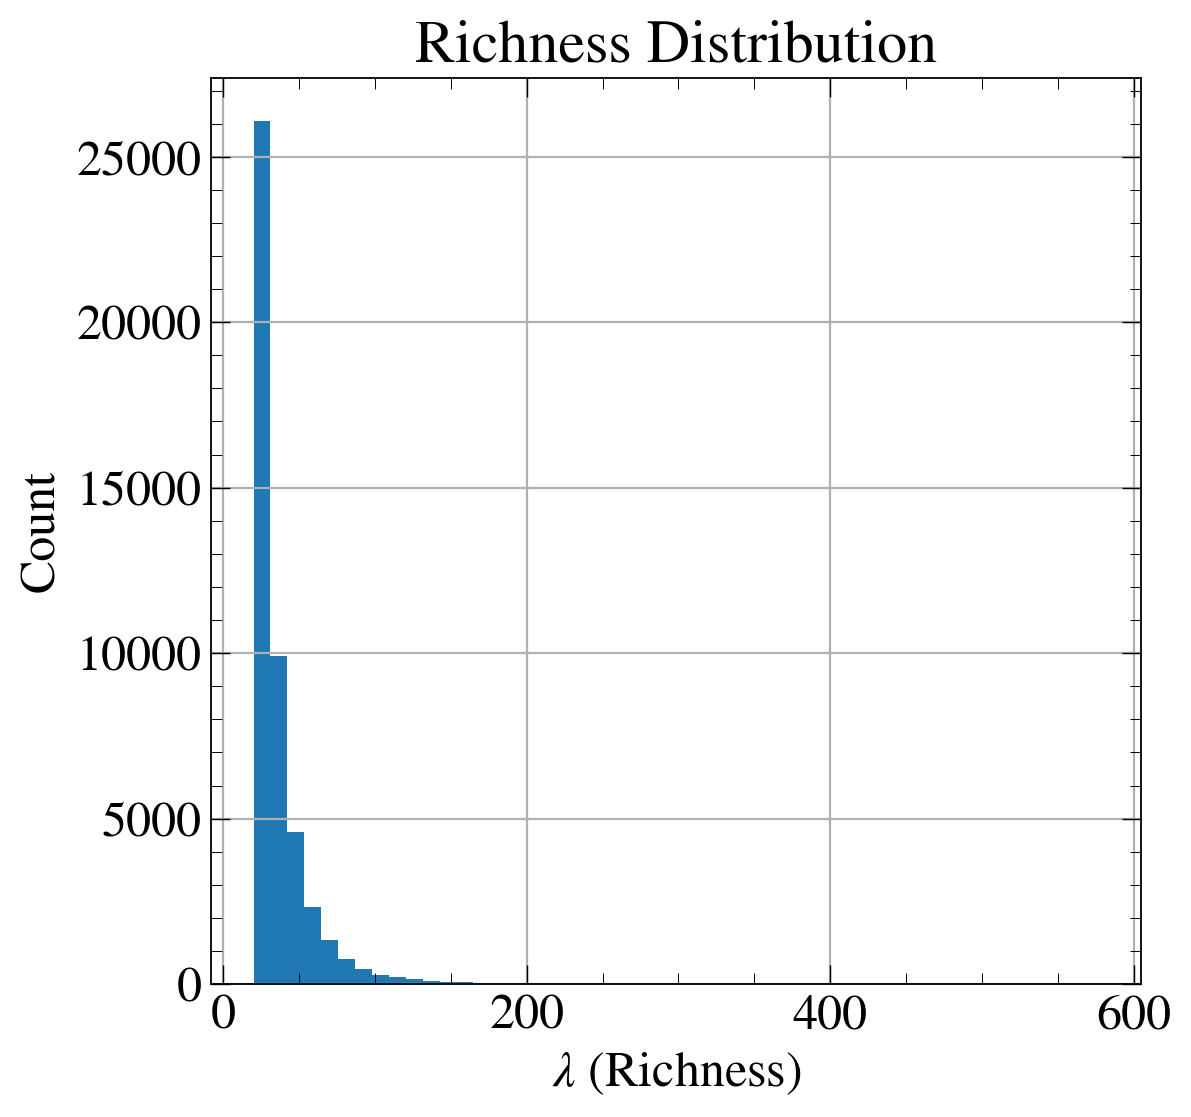

In [29]:
# Plotting the richness distribution
print(redmapper_cl['richness'].min(), len(redmapper_cl[redmapper_cl['richness']>200]))
plt.hist(redmapper_cl['richness'], bins=50)
plt.title('Richness Distribution')
plt.xlabel(r'$\lambda$ (Richness)')
plt.ylabel('Count')
# plt.savefig('Images/Richness Distribution.jpg')
plt.show()

## Load the Halos (GCR)

In [30]:
## Sigma and DS profile
file_path = r"/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/"

sigma_ds_profile = pd.read_pickle(file_path + 'Data/WL-Signal/skysim-full-2152757-1.1.1.csv')
sigma_ds_profile = Table.from_pandas(sigma_ds_profile)
sigma_ds_profile['halo_id'] = sigma_ds_profile['halo_id'].astype(int)
print(len(sigma_ds_profile))

### SOD mass with -1
# (sigma_ds_profile['baseDC2/sod_halo_mass']== -1.0).sum()

2152757


In [31]:
# lambda_30 = Table.read(file_path + 'Data/halos/RichnessDepth_30.dat', format='ascii')
# print(len(lambda_30))
# print(len(lambda_30[lambda_30['lam']>9]))

In [32]:
redmapper_cl = redmapper_cl[(redmapper_cl['redshift']>=0.2) & (redmapper_cl['redshift']<=1)] #38284
print(len(redmapper_cl))

38630


In [33]:
perfect_match = join(redmapper_cl, sigma_ds_profile, join_type='inner', keys=['dec','ra']) #[cluster_halo['redshift_2']==None] #.pprint(max_width=-1)
unmatchedRedCl = redmapper_cl[~np.isin(redmapper_cl['cluster_id'],perfect_match['cluster_id'])] # 5092
print(len(unmatchedRedCl))
unmatchedhalos = sigma_ds_profile[~np.isin(sigma_ds_profile['halo_id'],perfect_match['halo_id'])]

5280


In [34]:
len(set(perfect_match['cluster_id'])), len(set(perfect_match['halo_id'])), len(redmapper_cl), len(sigma_ds_profile)#, len(unmatched)

(33350, 33350, 38630, 2152757)

0.21128913966692475


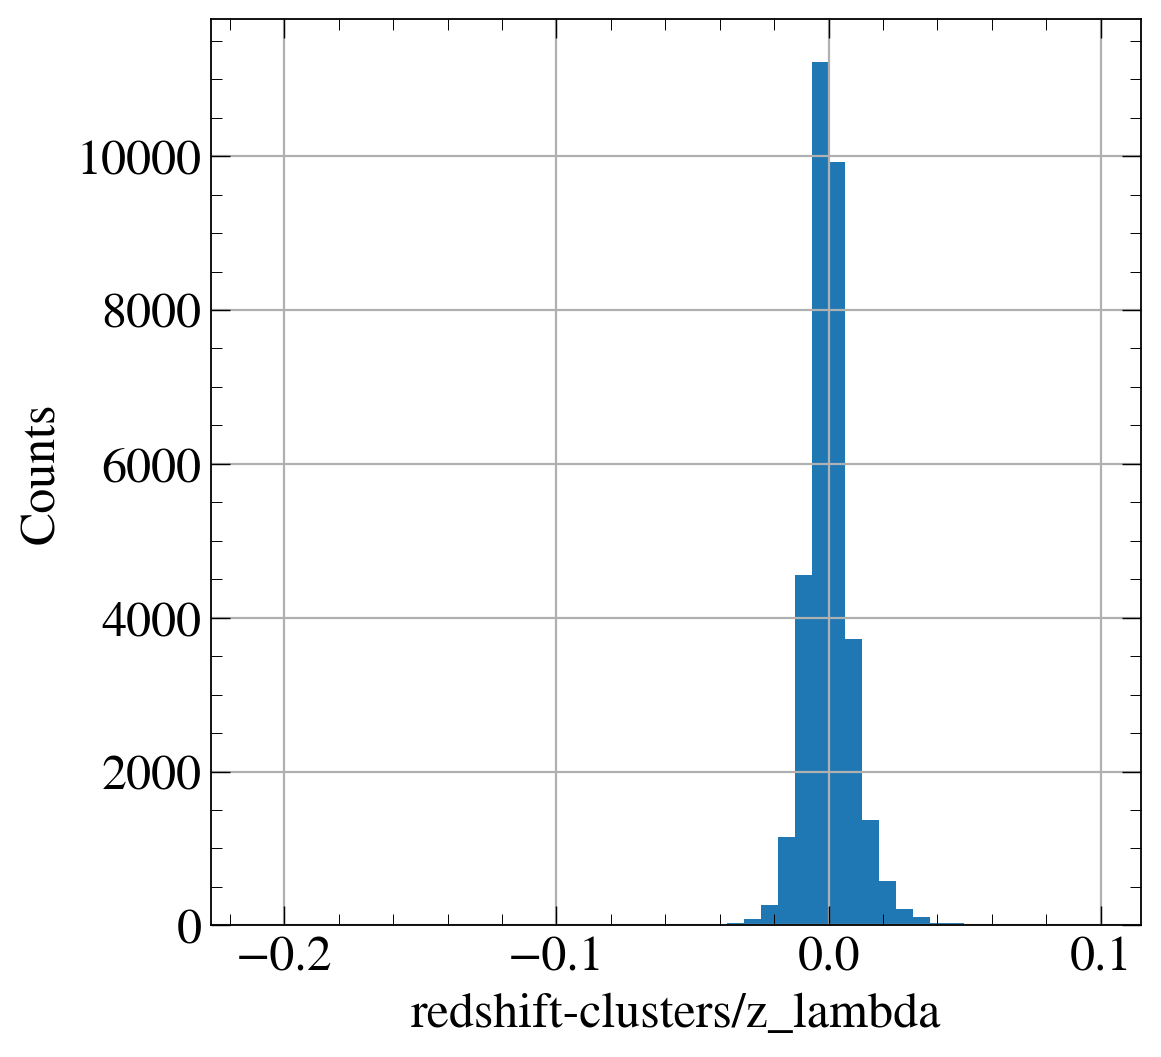

In [35]:
print((np.abs(perfect_match['redshift_2'] - perfect_match['clusters/z_lambda'])).max())
plt.hist(perfect_match['redshift_2'] - perfect_match['clusters/z_lambda'], bins=50)
plt.ylabel('Counts')
plt.xlabel('redshift-clusters/z_lambda')
plt.show()

## Setting tolerance for matching the remaining RedMaPPer clusters with halos

In [36]:
unmatchedhalos['sc'] = SkyCoord(unmatchedhalos['ra'], unmatchedhalos['dec'], unit='deg')
unmatchedRedCl['sc'] = SkyCoord(unmatchedRedCl['ra'], unmatchedRedCl['dec'], unit='deg')

In [37]:
matched_SC = join(unmatchedRedCl, unmatchedhalos, keys='sc', join_funcs={'sc': join_skycoord(0.01 * u.deg)})
print(len(matched_SC))

filtered_table = Table(names=matched_SC.colnames, dtype=matched_SC.dtype)

grouped_table = matched_SC.group_by('sc_id')
for group in grouped_table.groups:
    if len(group) == 1:
        filtered_table.add_row(group[0])
    else:
        redshift_diff = np.abs(group['redshift_2'] - np.median(group['clusters/z_lambda']))
        min_diff_idx = np.argmin(redshift_diff)
        filtered_table.add_row(group[min_diff_idx])
        
print(len(np.unique(filtered_table['clusters/mem_match_id']))) # 4998, 79687
filtered_table[:5]

5416
4636


sc_id,richness,redshift_1,cluster_id,clusters/z_lambda,clusters/mem_match_id,ra_1,dec_1,sc_1,halo_id,radius,sigma,DS,baseDC2/sod_halo_mass,baseDC2/sod_halo_radius,redshift_2,dec_2,magnification,hostHaloMass,ra_2,halo_mass,pixel_id,sc_2
int64,float32,float32,int32,float32,int32,float64,float64,object,int64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,int64,object
1,87.18639,0.5912586,1365,0.5912586,1365,2.896798269949837,-1.5203787028802902,"<SkyCoord (ICRS): (ra, dec) in deg (2.89679827, -1.5203787)>",1175106209307,[ 0.12066658 0.20876324 0.32991475 0.5190142 0.81689462 1.31146216 2.08315879 3.29076809 5.21049084 8.27816537 13.17315125 20.81186427 32.87894453 51.48946126 71.82662178],[3.78443580e+14 3.78249789e+14 2.46092859e+14 1.90425756e+14 1.05690770e+14 5.83481549e+13 5.11911053e+13 1.69519155e+13 6.03060082e+12 1.15663979e+13 1.95713205e+13 1.02512026e+13 1.14863385e+13 1.16180109e+13 2.13035083e+11],[ 3.75410217e+13 -3.66477849e+13 6.75762380e+13 6.71134143e+13 7.26765200e+13 6.25315329e+13 3.08318870e+13 2.70515330e+13 2.16706655e+13 3.82121772e+12 -2.52768126e+12 3.87473997e+12 1.75838567e+12 2.25423212e+12 3.25145604e+12],215036714811392.0,1.2696400880813599,0.5910195826867897,-1.5172599429600495,0.9981635619495411,299062196699136.0,2.8949591873192695,421214361548078.9,6209,"<SkyCoord (ICRS): (ra, dec) in deg (2.89495919, -1.51725994)>"
2,53.274582,0.5922861,6286,0.5922861,6286,3.9520044556241634,-1.2222302793974655,"<SkyCoord (ICRS): (ra, dec) in deg (3.95200446, -1.22223028)>",30606209307,[ 0.12036234 0.20523745 0.32377581 0.53051547 0.83263312 1.31692572 2.07938227 3.30329598 5.2191617 8.26032934 13.20850174 20.81485787 32.46933048 50.74158685 77.03411366],[ 6.48105096e+14 4.95516152e+14 1.97734220e+14 1.17639769e+14 1.34932506e+14 6.24589733e+13 2.69948913e+13 -1.58706257e+12 1.24840840e+13 8.17067057e+12 1.33920323e+13 6.45907908e+12 1.02380694e+13 1.35767261e+13 6.63220344e+12],[ 7.94778294e+13 1.31287935e+14 1.89653490e+14 1.55558154e+14 6.32017202e+13 6.02494621e+13 4.98183421e+13 3.65737367e+13 5.84741026e+12 6.09607089e+12 3.19356144e+11 3.35095290e+12 -4.65118755e+11 -2.40517914e+12 3.92186767e+12],309910478782464.0,1.4341225624084473,0.5917466111825231,-1.229060036928648,0.99440885023363,294197475147776.0,3.9539879408698955,414362641053205.6,6209,"<SkyCoord (ICRS): (ra, dec) in deg (3.95398794, -1.22906004)>"
3,51.672813,0.73358476,7309,0.73358476,7309,7.237337018664522,-1.7915726702320818,"<SkyCoord (ICRS): (ra, dec) in deg (7.23733702, -1.79157267)>",503406338286,[ 0.10852191 0.20654213 0.33366425 0.54059278 0.79853654 1.32988783 2.07156113 3.27970028 5.18509778 8.28265287 13.15084029 20.847857 33.07955646 51.37241776 78.54487462],[ 5.97047164e+14 4.64426701e+14 2.31209217e+14 1.43062297e+14 1.31643615e+14 2.60452282e+13 3.08569805e+12 1.69986359e+13 -7.47258264e+12 -1.10181153e+13 -1.96112683e+12 -1.29784102e+13 3.31237654e+11 1.46021282e+12 4.84416984e+12],[-8.23545872e+13 7.59386862e+13 1.39378293e+14 1.24807121e+14 7.42275040e+13 8.65234652e+13 4.60040182e+13 6.54084020e+12 1.91366077e+13 1.01055858e+13 -1.40122032e+12 7.20872445e+12 -5.86016169e+12 -2.49148526e+12 -1.62885103e+12],137055065604096.0,1.12343430519104,0.724829526271753,-1.789699135266021,1.0055861953410596,159541006172160.0,7.233703647140288,224705642496000.0,6338,"<SkyCoord (ICRS): (ra, dec) in deg (7.23370365, -1.78969914)>"
4,43.45038,0.24652696,9909,0.24652696,9909,2.131558544832236,-0.7840742485998262,"<SkyCoord (ICRS): (ra, dec) in deg (2.13155854, -0.78407425)>",320806209392,[ 0.14039431 0.1982112 0.32922544 0.50957421 0.82099174 1.31408102 2.10438765 3.29834321 5.23708481 8.34319871 12.92368315 20.74672763 32.12436714 47.86142371 64.92487301],[ 8.65397037e+14 3.77034175e+14 2.43230857e+14 1.28690392e+14 5.32235853e+13 1.97884478e+13 1.60641290e+13 -5.12978506e+12 -1.13678520e+13 8.38292414e+10 -4.74380547e+11 -2.74256118e+09 3.87793180e+12 -3.71151196e+12 -3.11831983e+12],[ 1.96902461e+1

0.7316537396247196 -0.707950701651606


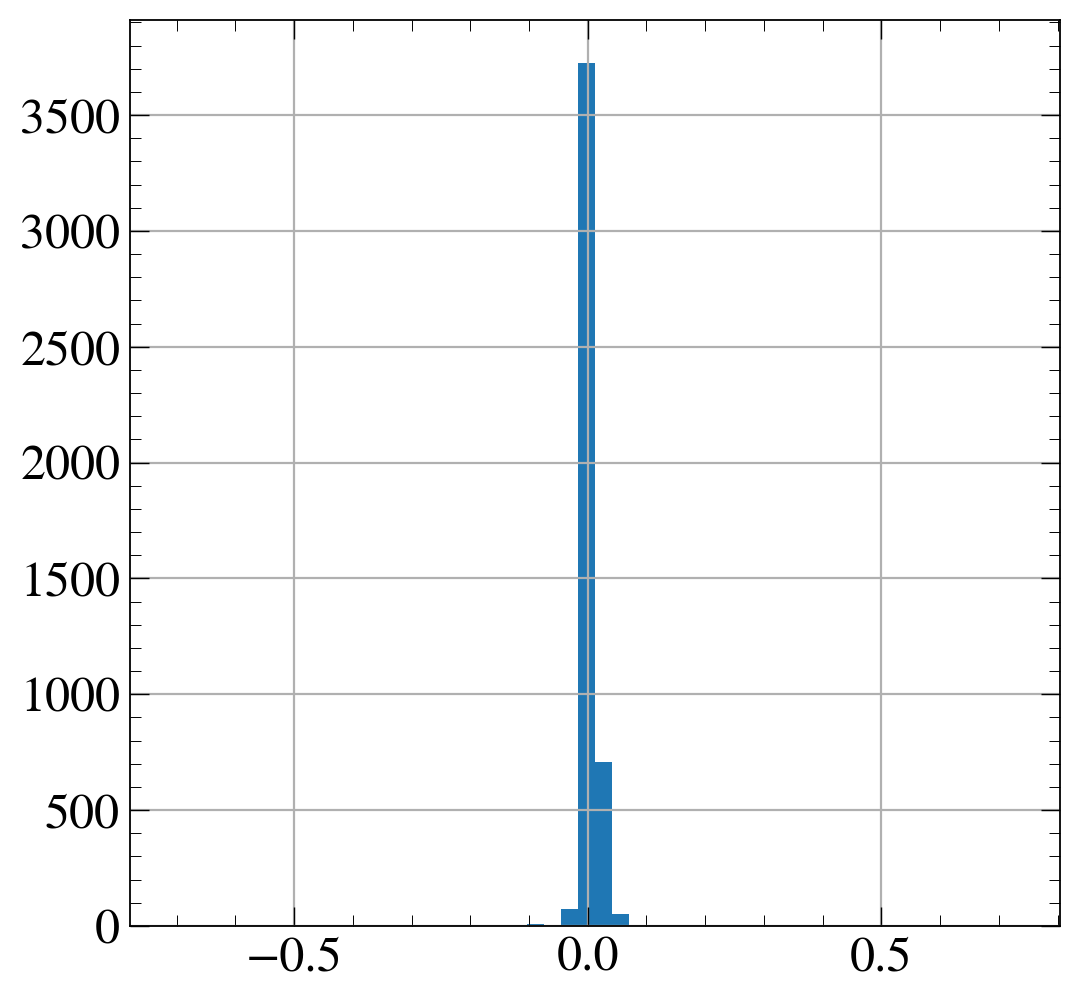

In [38]:
print((filtered_table['redshift_2'] - filtered_table['clusters/z_lambda']).max(), (filtered_table['redshift_2'] - filtered_table['clusters/z_lambda']).min())
plt.hist(filtered_table['redshift_2'] - filtered_table['clusters/z_lambda'], bins=50)
plt.show()
## 0.043500185 -0.17677367

In [39]:
filtered_table['ra_1','ra_2','dec_1','dec_2']

ra_1,ra_2,dec_1,dec_2
float64,float64,float64,float64
2.896798269949837,2.8949591873192695,-1.5203787028802902,-1.5172599429600495
3.9520044556241634,3.9539879408698955,-1.2222302793974655,-1.229060036928648
7.237337018664522,7.233703647140288,-1.7915726702320818,-1.789699135266021
2.131558544832236,2.1354624026440834,-0.7840742485998262,-0.7912703130140275
7.622600010501734,7.624281569585428,-1.1842702769604658,-1.1864275777400628
1.1479846800139455,1.146846863248177,-0.7544516461480844,-0.7531188880601637
10.059253567466481,10.060982728203722,-0.03005200287649117,-0.030268594680434694
8.071501029295197,8.07021981174232,-2.452941291744379,-2.4552378671755704
3.6479038402894,3.65027467336941,-2.305724221779252,-2.3126024949797044


In [40]:
filtered_table.remove_columns(['ra_1','dec_1','sc_id','sc_1','sc_2'])
filtered_table.rename_columns(['ra_2','dec_2'],['ra','dec'])

In [41]:
perfect_match.columns

<TableColumns names=('richness','redshift_1','cluster_id','clusters/z_lambda','clusters/mem_match_id','ra','dec','halo_id','radius','sigma','DS','baseDC2/sod_halo_mass','baseDC2/sod_halo_radius','redshift_2','magnification','hostHaloMass','halo_mass','pixel_id')>

In [42]:
filtered_table.columns

<TableColumns names=('richness','redshift_1','cluster_id','clusters/z_lambda','clusters/mem_match_id','halo_id','radius','sigma','DS','baseDC2/sod_halo_mass','baseDC2/sod_halo_radius','redshift_2','dec','magnification','hostHaloMass','ra','halo_mass','pixel_id')>

In [43]:
cluster_halo = vstack([perfect_match, filtered_table])

In [46]:
# cluster_halo = cluster_halo.to_pandas()
# cluster_halo.to_pickle(file_path + 'Data/halos/halos_redmapper.csv')
# pd.read_pickle(file_path + 'Data/halos/halos_redmapper.csv')

In [52]:
perfect_match['ra'] = np.round(perfect_match['ra']* np.pi / 180., 5)
perfect_match['dec'] = np.round(perfect_match['dec']* np.pi / 180., 5)

In [53]:
lambda_30['ra'] = np.round(lambda_30['ra'],5)
lambda_30['dec'] = np.round(lambda_30['dec'],5)

In [62]:
HaloRedDepth = astropy.table.join(perfect_match, lambda_30, join_type='inner', keys=['ra','dec','halo_id'])
len(HaloRedDepth)
HaloRedDepth['halo_id','ra','dec','redshift_1','lambda','redshift_2','pixel_id','lam','pixelid'] 

halo_id,ra,dec,redshift_1,lambda,redshift_2,pixel_id,lam,pixelid
int64,float64,float64,float32,float32,float64,float64,int64,int64
101409536373,0.00132,-0.61435,0.31267366,40.536682,0.31162510629024576,9536.0,38,9536
162408768373,0.00166,-0.45097,0.29612523,27.615717,0.3082585470475798,8768.0,26,8768
155509280373,0.00455,-0.55106,0.29582673,36.2958,0.3081845242865422,9280.0,34,9280
51207744373,0.00511,-0.28014,0.3171939,20.735723,0.31989548621561803,7744.0,17,7744
389709408373,0.01006,-0.56566,0.30950403,32.115936,0.3071034176280796,9408.0,28,9408
334409664373,0.01037,-0.61817,0.30571723,35.3805,0.31420383979492494,9664.0,34,9664
295711276373,0.01382,-1.00414,0.30538338,28.714075,0.3104116360462379,11276.0,18,11276
472908640373,0.01686,-0.41575,0.29214948,25.083391,0.30490870587787566,8640.0,26,8640
40609664373,0.01795,-0.61867,0.31007683,44.625015,0.31451982885990826,9664.0,40,9664


## Investigating the unmatched redmapper clusters

In [28]:
# ## Convert all the ra and dec of skysim halos to pixel id
# nside = 32
# pixelId = []   #162
# for i in range(len(unmatched)):
#     pixel_id = hp.pixelfunc.ang2pix(nside, unmatched['ra'][i], unmatched['dec'][i], lonlat=True)
#     # print(hpix)
#     pixelId.append(pixel_id)
# print(len(pixelId),'\n', len(np.unique(pixelId)))

# unmatched['pixel_id'] = pixelId

In [29]:
# halos_5241 = Table.read('/global/u1/k/kamau/SE-CLMM-LSSTDESC/cosmoDC2/Data/halos/skysim_0.2-1-5241.dat', format='ascii')
# perfect_match2 = astropy.table.join(Table.from_pandas(unmatched), halos_5241, join_type='inner', keys=['dec', 'ra', 'pixel_id'])
# perfect_match2['redshift_1'].name = 'redshift'
# print(len(perfect_match2))
# unmatched2 = setdiff(Table.from_pandas(unmatched),perfect_match2)
# print(len(unmatched2))

In [30]:
# len(set(perfect_match2['mem_match_id'])), len(set(perfect_match2['halo_id'])), len(redmapper_cl), len(sigma_ds_profile), len(unmatched2)

In [31]:
# diff = setdiff(halos_5241,halos, keys=['halo_id'])
# print(len(diff))
# '{:.3e}'.format(diff['halo_mass'].max())

# Richness Mass Relation

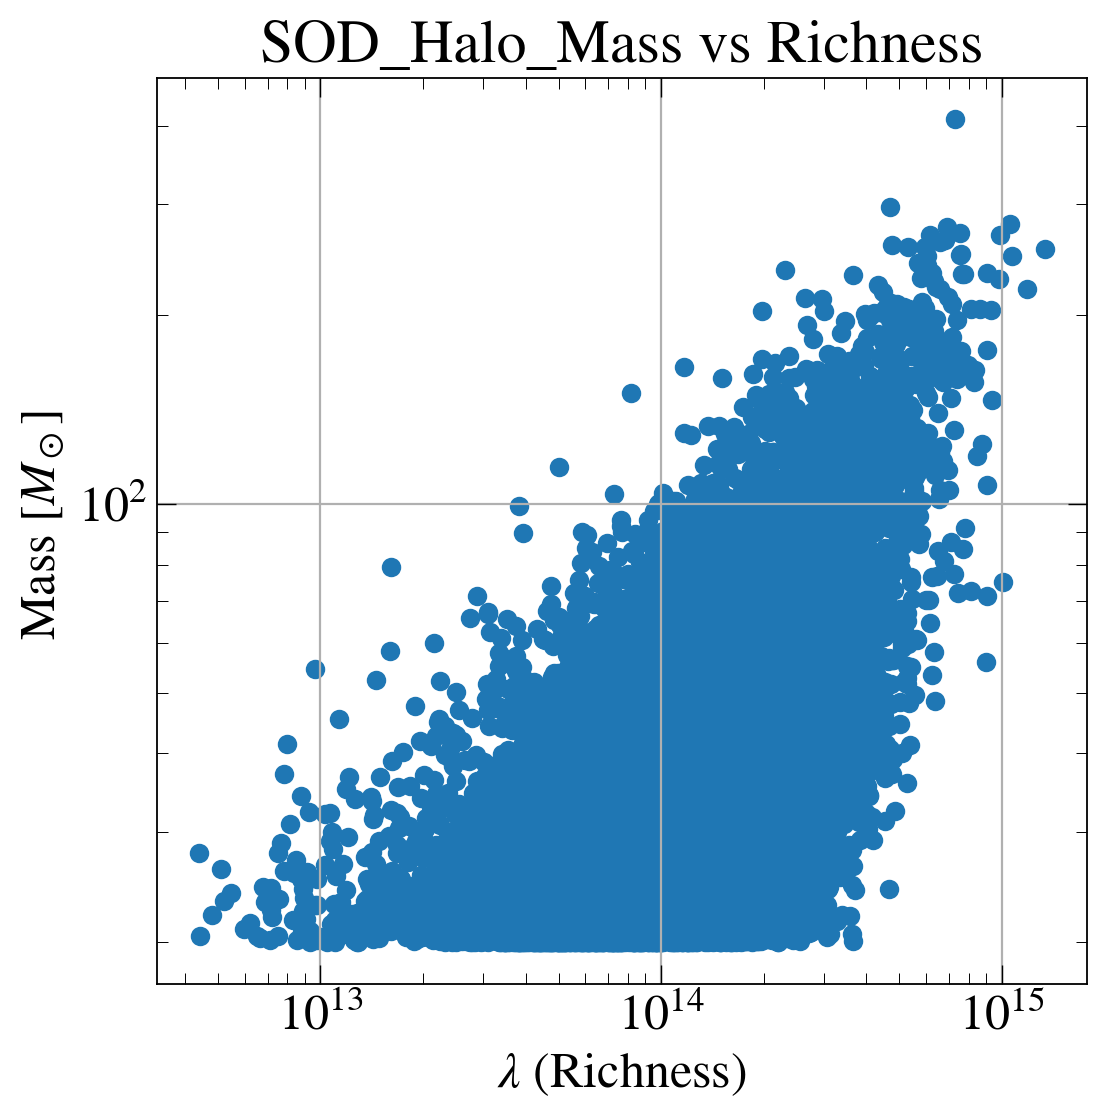

In [112]:
plt.scatter(perfect_match['baseDC2/sod_halo_mass'], perfect_match['lambda'])
plt.yscale('log')
plt.xscale('log')
plt.title('SOD_Halo_Mass vs Richness')
plt.xlabel(r'$\lambda$ (Richness)')
plt.ylabel(r' Mass [$M_\odot$]')
plt.show()

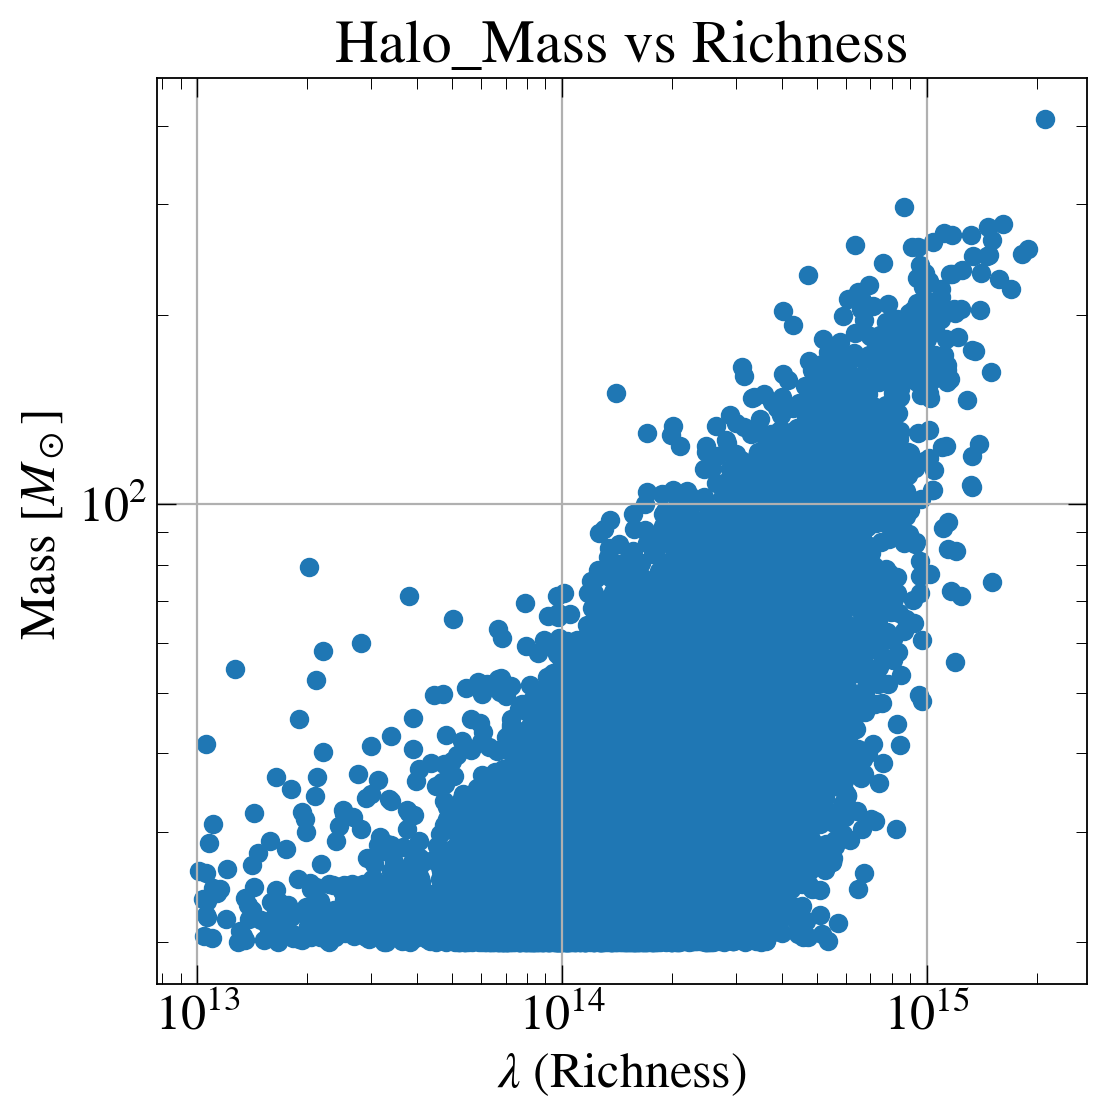

In [113]:
plt.scatter(perfect_match['halo_mass'], perfect_match['lambda'])
plt.yscale('log')
plt.xscale('log')
plt.title('Halo_Mass vs Richness')
plt.xlabel(r'$\lambda$ (Richness)')
plt.ylabel(r' Mass [$M_\odot$]')
plt.show()

## Fitting M200c vs richness using the kllr package

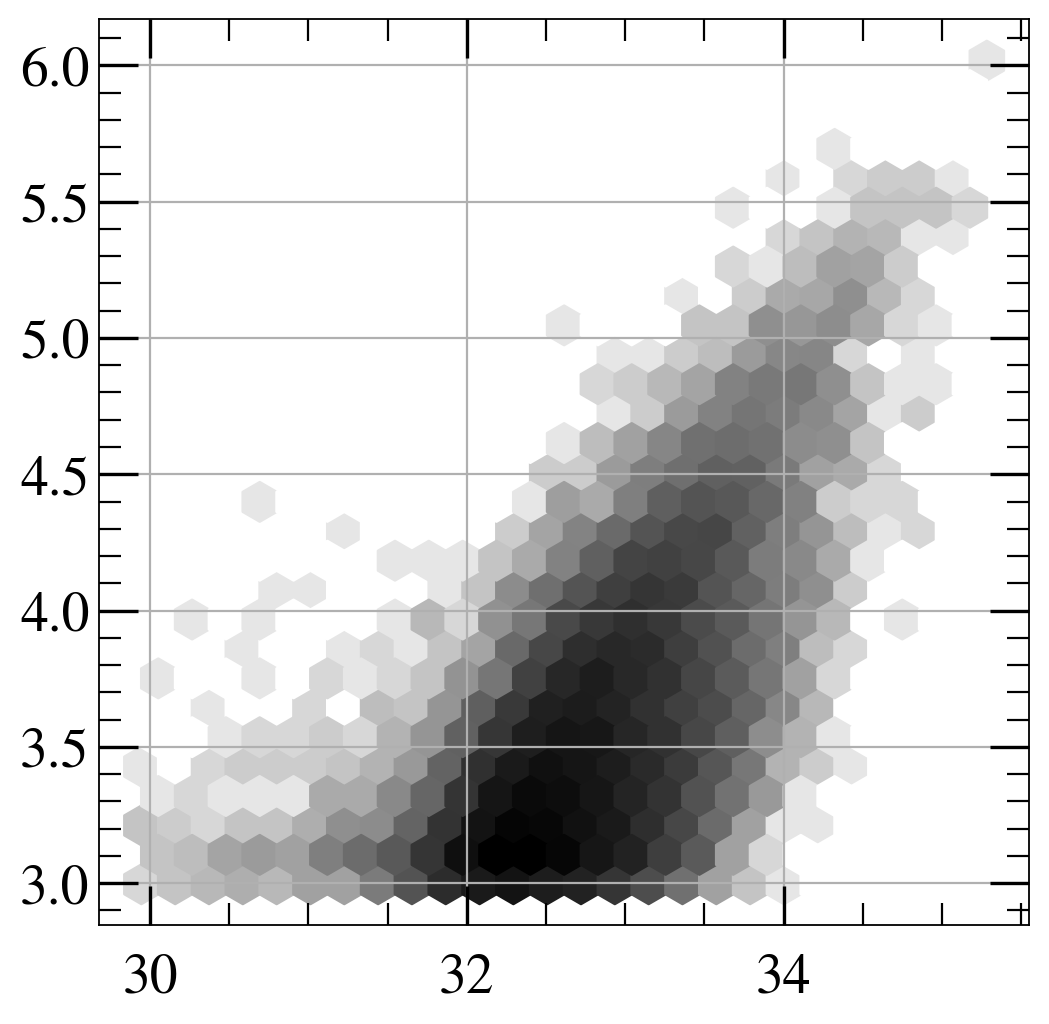

In [118]:
mass = perfect_match['halo_mass']
lam = perfect_match['lambda']
# sel = (perfect_match['lambda'] > 0) & (m200c > 1e13)
x = np.log(mass)
y = np.log(lam)

## plot hexbin
plt.hexbin( x,y, gridsize=25, bins='log', cmap='gray_r')

/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/kllr/regression_model.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(X.shape) == 1: X = X[:, None] #Make sure X is atleast 2D


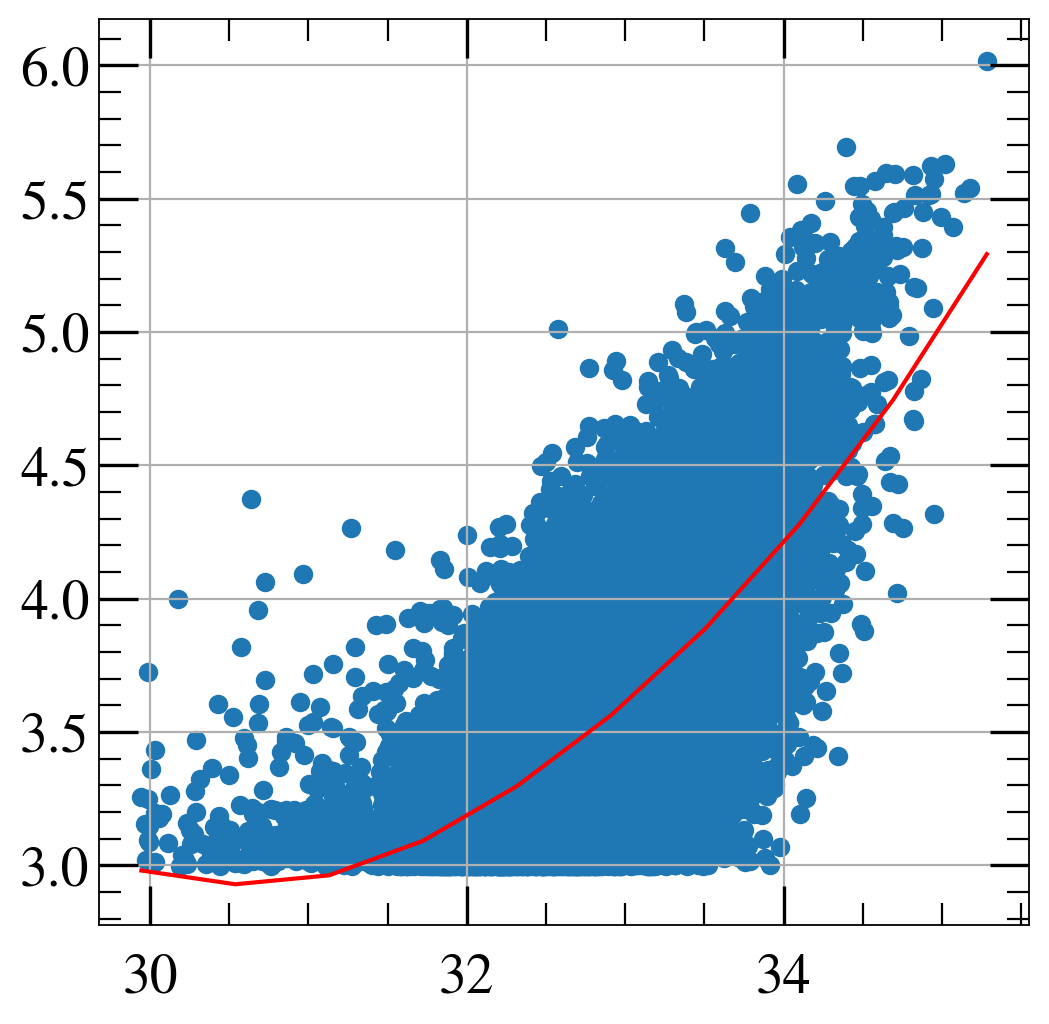

In [120]:
from kllr import kllr_model, Plot_Fit_Summary
lm = kllr_model(kernel_type = 'gaussian', kernel_width = 1)
bins = 10
x_bin, yrange_mean, intercept, slope, scatter, skew, kurt = lm.fit(x, y, bins=bins)  
y_fit = np.mean(yrange_mean, axis=0)
plt.scatter( x, y)
plt.plot(x_bin, y_fit,   c='r')

100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


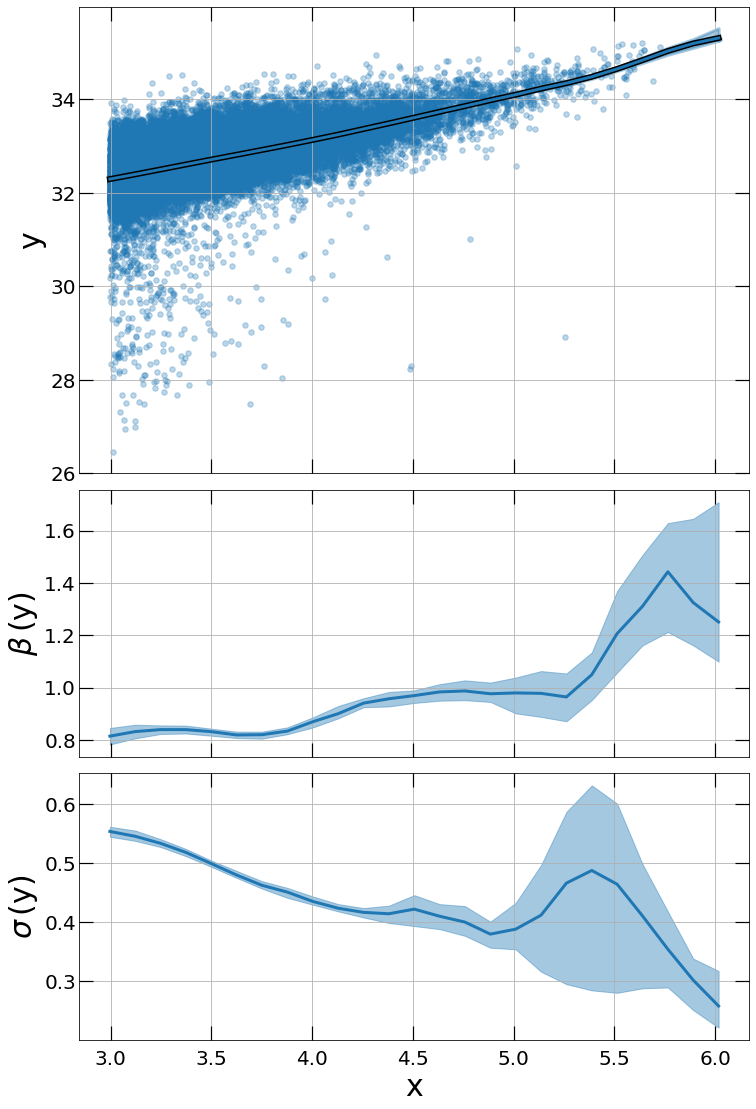

In [36]:
dictt = {'x' : x,
        'y': y}
df = pd.DataFrame(dictt)
 
Plot_Fit_Summary(df,'x','y', show_data=True)
plt.show()

## Extract halos (less filters) to find more match with redmapper clusters

In [115]:
# s_ds = pd.DataFrame(columns=['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id','magnification',
#                                              'baseDC2/sod_halo_mass','baseDC2/sod_halo_radius','is_central'])

In [125]:
# skysim = gcr.load_catalog('skysim5000_v1.1.1')
# mmin = 1.e13 #1.e14
# zmin = 0.2
# zmax = 1


# for pixel in np.unique(unmatched2['pixel_id']):
#     sky_02_1 = Table(skysim.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id','magnification',
#                                              'baseDC2/sod_halo_mass','baseDC2/sod_halo_radius','is_central'],
#                                              native_filters=f'healpix_pixel == {pixel}'))
    
#     sub_matching = astropy.table.join(sky_02_1, unmatched2, join_type='inner', keys=['ra', 'dec'], join_funcs={'dec': astropy.table.join_distance(1e-8),
#                                                                                                             'ra': astropy.table.join_distance(1e-8)})
#     sub_matching = sub_matching.to_pandas()
#     s_ds = pd.concat([sub_matching,s_ds])
    

In [37]:
'{:.3e}'.format(s_ds['halo_mass'][s_ds['is_central']==True].max())

'9.956e+12'

In [128]:
# s_ds = s_ds[['baseDC2/sod_halo_mass','baseDC2/sod_halo_radius','redshift_1','dec_1','magnification',
#             'hostHaloMass','ra_1','halo_id','halo_mass','pixel_id']]
# s_ds = s_ds.rename(columns={"redshift_1": "redshift", "ra_1": "ra","dec_1": "dec" })


In [129]:
# s_ds = Table.from_pandas(s_ds)

# s_ds.write('/global/u1/k/kamau/SE-CLMM-LSSTDESC/cosmoDC2/Data/halos/skysim_0.2-1-7786.dat', format='ascii')